# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Nonnegative_Antisparse_Copula'

In [3]:
# @njit
# def numpy_tanh(x):
#     return np.tanh(x)
# numpy_tanh(np.array([1,2,0.4]))

# Source Generation and Mixing Scenario

In [4]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources
INPUT_STD = 0.28
SNR = 30 # dB

# Generate the sources and mixtures
S, X, A = generate_synthetic_data_SMICA(seed=105)

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.03178472761709


# Visualize Generated Sources and Mixtures

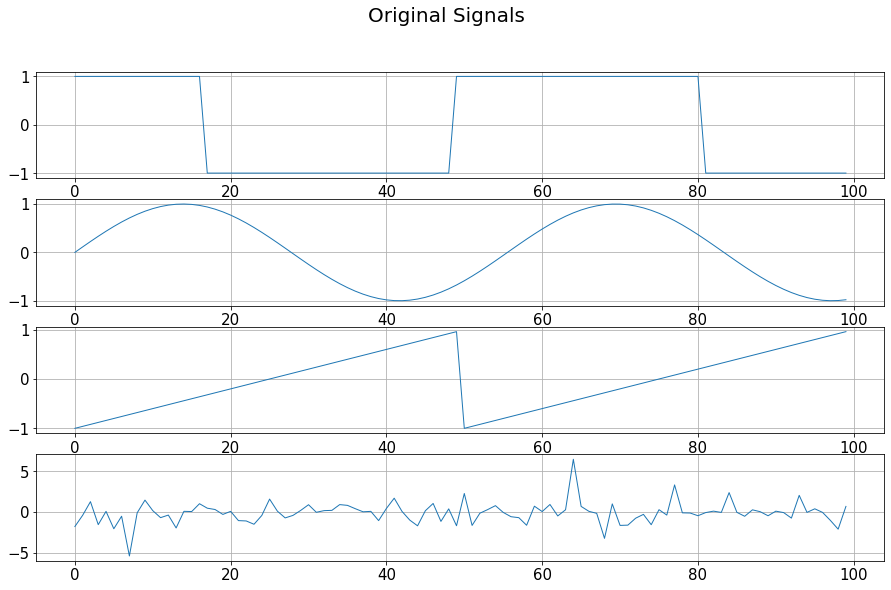

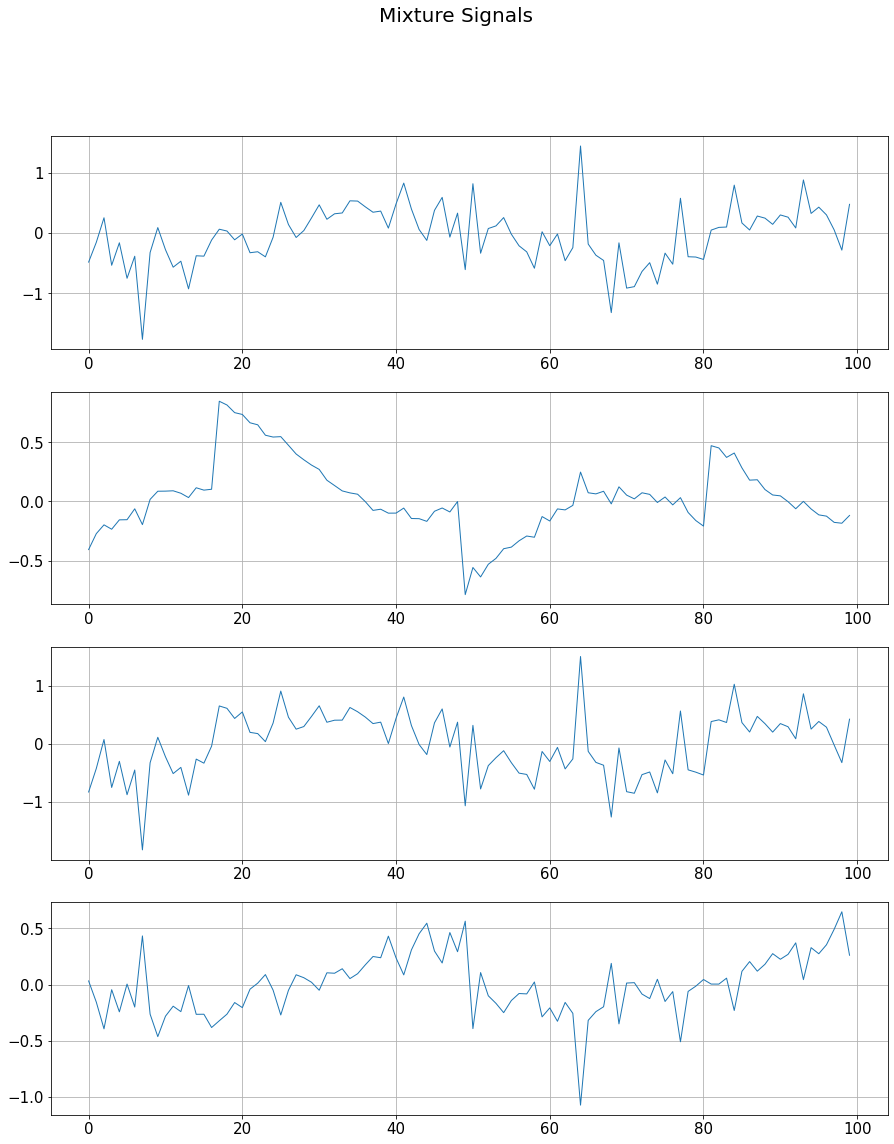

In [5]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [6]:
# gamma_start = 0.25
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-7
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [4,1]
# LayerMinimumGains = [1e-3,1e-3]
# LayerMaximumGains = [1e6,20]
# WScalings = [0.0033,0.0033]
# GamScalings = [1,1]
# zeta = 1*1e-5
# beta = 0.5
# muD = [10, 1e-3]
# # # OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
# synaptic_lr_rule = "divide_by_log_index" 
# # # OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
# neural_loop_lr_rule = "divide_by_slow_loop_index"
# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

# gamma_start = 0.1
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-6
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [0.5,0.5]
# LayerMinimumGains = [0.2,0.2]
# LayerMaximumGains = [1e6,5]
# WScalings = [0.005,0.005]
# GamScalings = [2,1]
# zeta = 5*1e-3
# beta = 0.5
# muD = [0.01, 0.01]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = x_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

gammaM_start = [0.1, 0.1]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [0.1, 0.1]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [0.5,0.5]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,50]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-3
beta = 0.5
muD = [0.01, 0.001]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)
output_activation = "tanh"

# OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
synaptic_lr_rule = "divide_by_log_index" 
# OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
neural_loop_lr_rule = "divide_by_slow_loop_index"

synaptic_lr_decay_divider = 15000
neural_lr_decay_multiplier = 0.01
hidden_layer_gain = 10

# Run WSM Algorithm on Mixture Signals

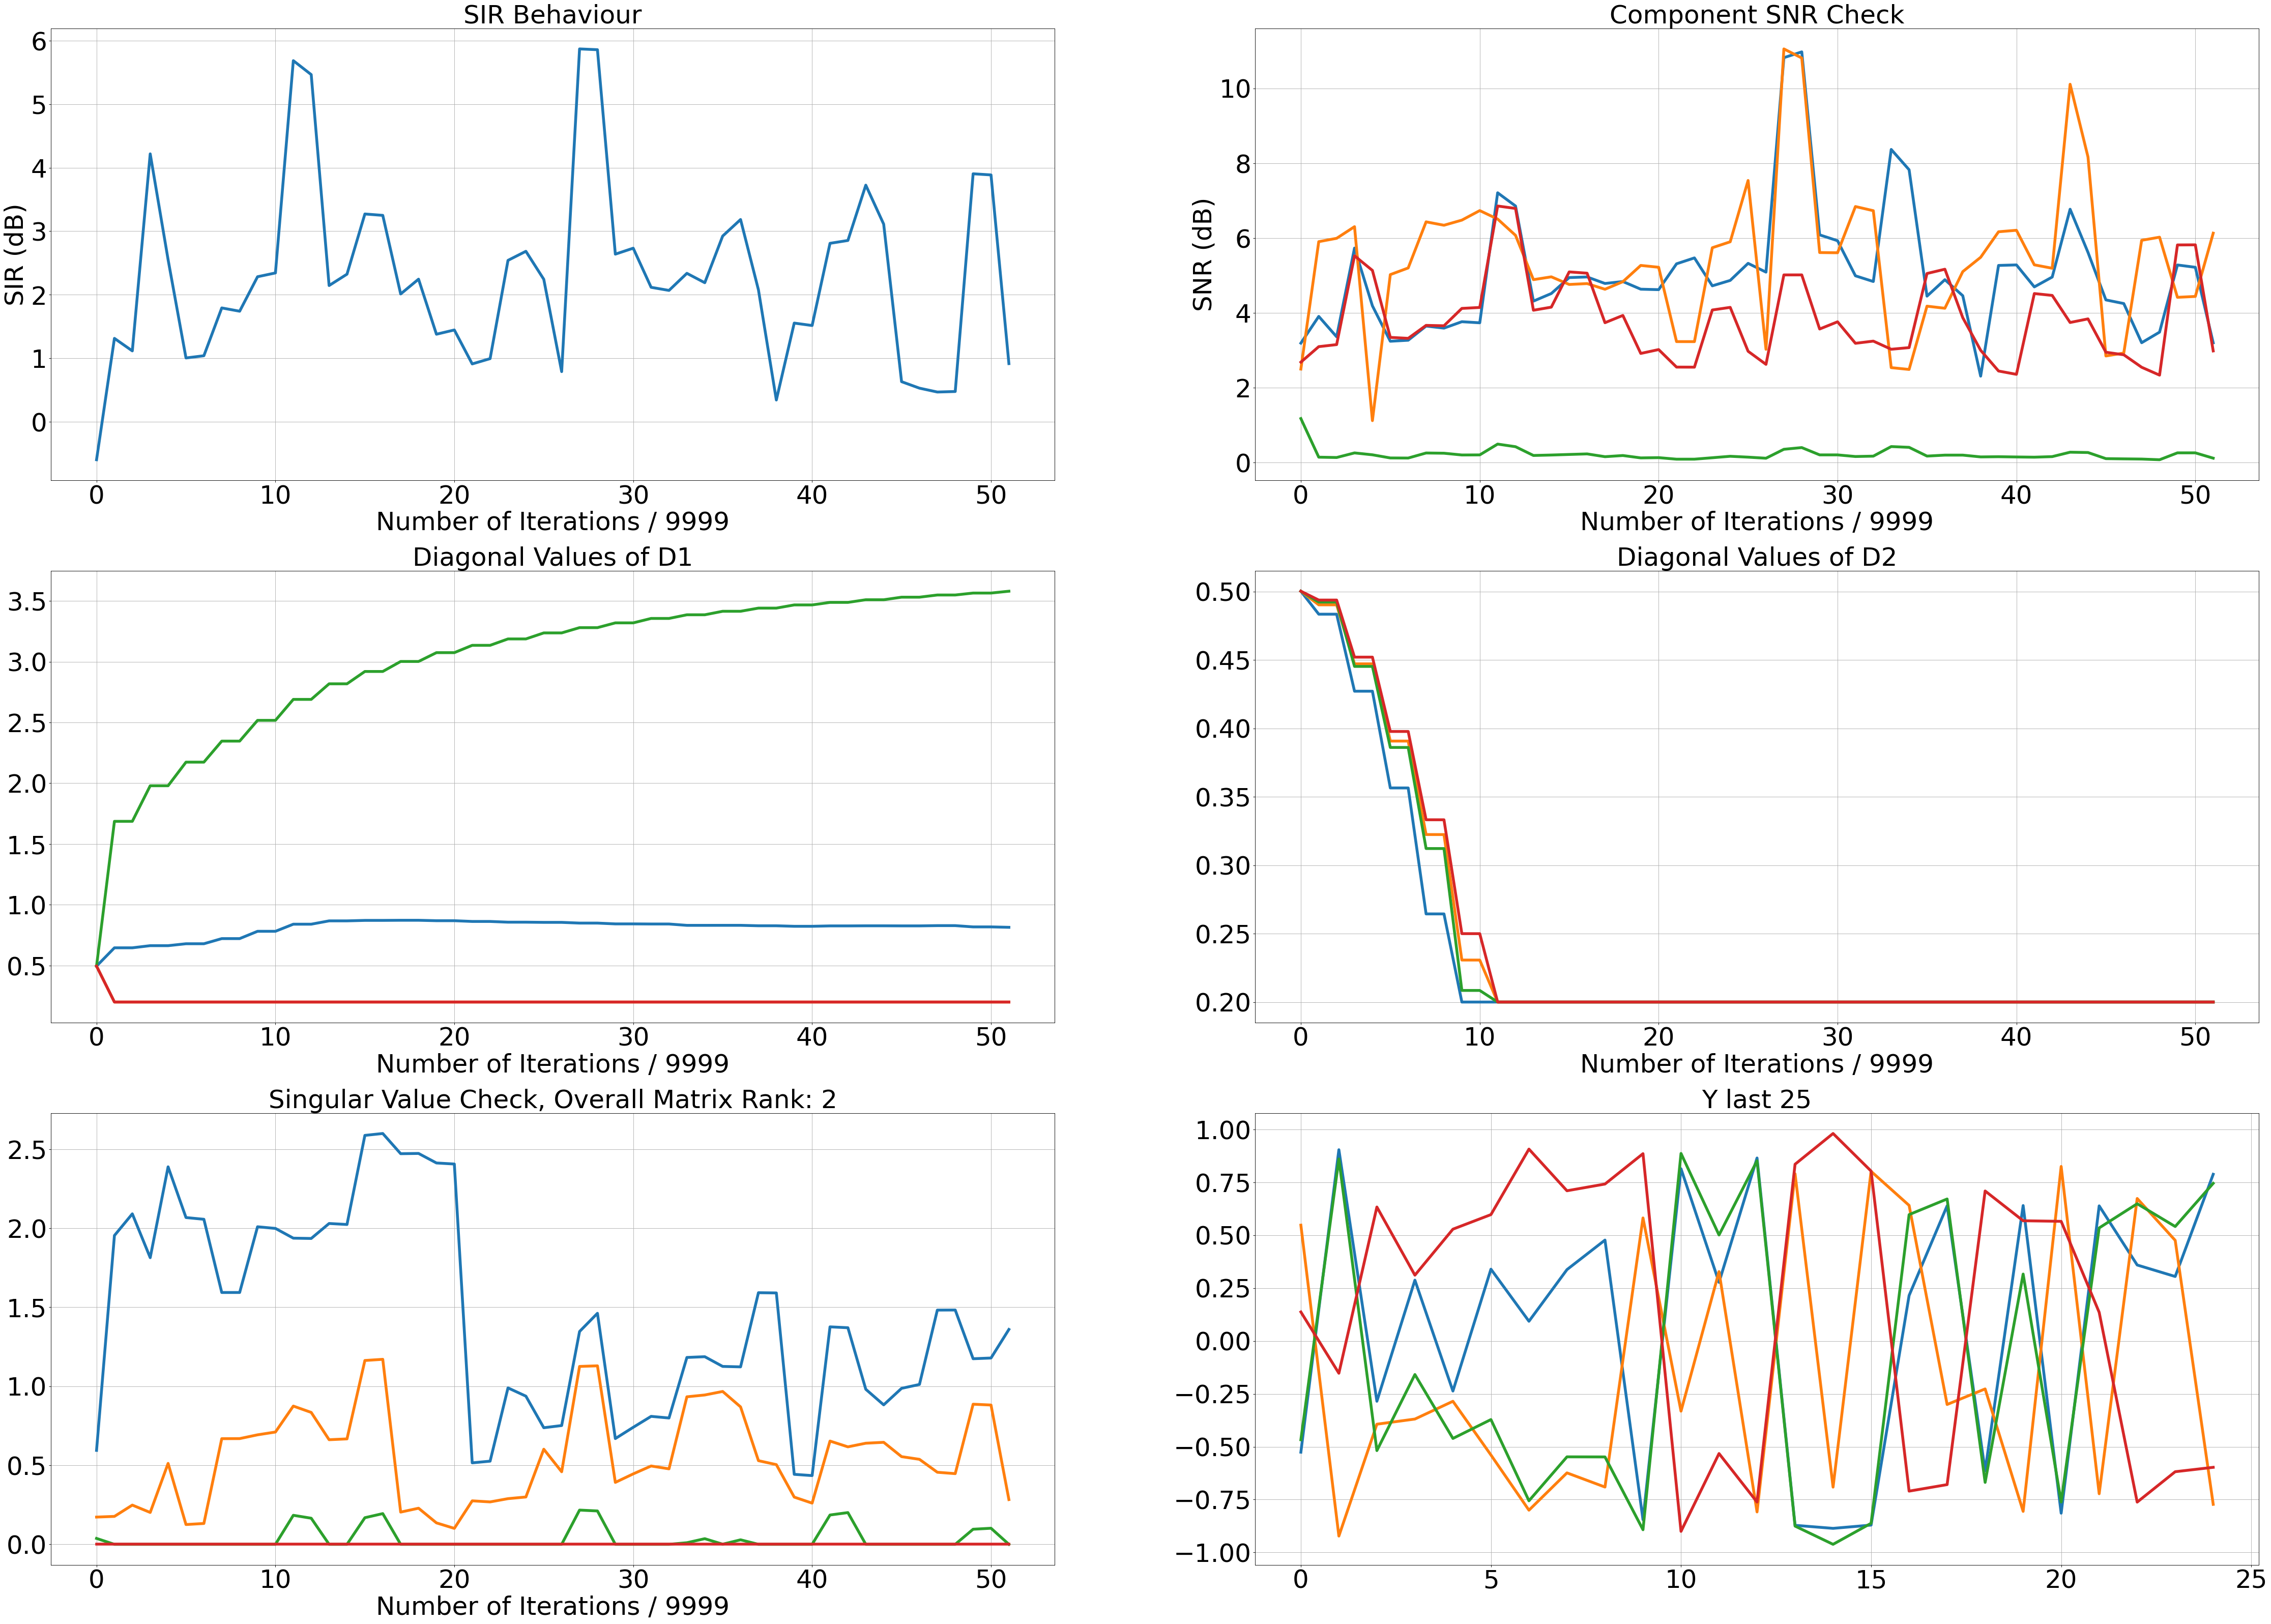

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
debug_iteration_point = 9999
modelWSM = OnlineWSMICA( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                         gammaW_start = gammaW_start, gammaW_stop = gammaW_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_ica(  X, n_epochs = 100, 
                         neural_dynamic_iterations = 250,
                         neural_lr_start = 0.75,
                         neural_lr_stop = 0.05,
                         synaptic_lr_rule = synaptic_lr_rule,
                         neural_loop_lr_rule = neural_loop_lr_rule,
                         debug_iteration_point = debug_iteration_point,
                         hidden_layer_gain = hidden_layer_gain, 
                         output_activation = output_activation,
                         plot_in_jupyter = True,
                        )

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)